In [12]:
%%capture
!pip install smart_open sklearn s3fs
!pip install https://s3-us-west-2.amazonaws.com/xgboost-nightly-builds/xgboost-1.2.0_SNAPSHOT%2Ba4de2f68e492065f5b90e83789a65388d349f0df-py3-none-win_amd64.whl

## Using Synthetics to balance data with extreme class imbalance

In this notebook we visualize the synthetic data set created using gretel-synthetics in Part 1, and use it to augment and boost the minority class in our fraud detection challenge set from Kaggle.

This notebook accompanies our Medium post at: https://medium.com/gretel-ai/improve-fraud-detection-under-an-extreme-class-imbalance-with-synthetic-data-7dd3d856bbdf 

In [13]:
# Set to false to compare results of the original dataset from Kaggle
# and the original dataset augmented with synthetic data
USE_SYNTHETIC_DATA = True

In [14]:
from sklearn.model_selection import train_test_split
from smart_open import open
import pandas as pd
import numpy as np

# Load datasets from S3
# Load or replace synthetic_set with your own generated file
training_set = 's3://gretel-public-website/datasets/creditcard_train.csv'
test_set = 's3://gretel-public-website/datasets/creditcard_test.csv'
synthetic_set = 's3://gretel-public-website/datasets/creditcard_synthetic.csv'
max_rows = 9999999

def load_csv(df_path, max_rows=max_rows):
    """ Load datasets from disk """
    df = pd.read_csv(df_path, nrows=max_rows).dropna()
    df = df.apply(pd.to_numeric, errors="coerce").dropna()
    return df.reset_index(drop=True)
      
train_only = load_csv(training_set)
test = load_csv(test_set)
synthetic = load_csv(synthetic_set)

if not USE_SYNTHETIC_DATA:
    synthetic = synthetic[0:0]

# combine training and synthetic boosted data
train = pd.concat([train_only, synthetic])

print("Source dataset dimensions")
print(f" -- Training data (rows, columns): {train.shape}")
print(f" -- Test data (rows, columns): {test.shape}")

Source dataset dimensions
 -- Training data (rows, columns): (8852, 31)
 -- Test data (rows, columns): (2000, 31)


In [15]:
# Preview the training dataset
train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2235,-1.787204,0.013612,2.249977,2.763243,0.746002,3.336379,-0.915483,-1.154089,0.612705,1.158881,1.238839,1.320342,-0.313427,-1.169979,-1.499442,-1.867284,1.411472,-2.018529,-0.333217,-0.958321,1.299637,0.148985,-0.030648,-0.973078,-1.345001,-0.030742,-0.080531,-0.189799,98.59,0
1,4833,1.021000,-0.083708,1.055318,1.605248,-0.289435,1.108695,-0.685134,0.406702,1.973717,-0.488662,1.932661,-1.351542,0.775229,1.378726,-1.827262,-0.925200,1.237457,-0.509727,-0.533960,-0.285997,-0.157535,0.124962,-0.040400,-0.339393,0.464752,-0.282935,0.054502,0.002592,15.00,0
2,2108,-0.386097,1.115191,1.274662,0.008660,0.254300,-0.500077,0.672194,0.037168,-0.473125,-0.571201,0.093082,0.264732,0.585162,-0.497726,1.092386,0.067395,0.259014,-0.646916,-0.453188,0.116085,-0.229752,-0.534956,0.011962,0.035986,-0.216450,0.099894,0.264855,0.096023,4.56,0
3,3138,-1.045938,0.610737,0.358115,-0.203802,-0.645612,-0.605557,1.136754,0.375660,-0.226405,-0.871793,-0.658783,-0.179832,-1.246345,0.628470,-0.376542,-0.366958,0.301025,-0.854270,-1.017236,0.118375,0.218629,0.400002,0.435944,0.394657,-0.428569,0.302804,0.177020,0.181093,183.29,0
4,10044,-0.996416,0.041710,2.450331,-0.613888,-0.709753,-0.570799,-0.167753,0.025144,1.820153,-1.086424,0.181111,-3.174768,0.827891,1.207836,0.404479,1.066242,-0.094182,0.771189,-1.130399,-0.187603,0.145444,0.559481,-0.081808,0.389500,-0.557130,0.883625,-0.054558,0.127527,83.47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
847,14073,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,-11.797181,11.277921,-16.728339,0.241368,-17.721638,-0.387300,-10.322017,-13.959085,-5.030710,1.197266,1.412625,1.976988,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,1.00,1
848,8808,-4.617217,1.695694,-3.114372,4.328199,-1.873257,-0.989908,-4.577265,0.472216,0.472017,-5.576023,4.802323,-10.833164,0.104304,-9.405423,-0.807478,-7.552342,-9.802562,-4.120629,1.740507,-0.039046,0.481830,0.146023,0.117039,-0.217565,-0.138776,-0.424453,-1.002041,0.890780,1.10,1
849,7535,0.026779,4.132464,-6.560600,6.348557,1.329666,-2.513479,-1.689102,0.303253,-3.139409,-6.045468,6.754625,-8.948179,0.702725,-10.733854,-1.379520,-1.638960,-1.746350,0.776744,-1.327357,0.587743,0.370509,-0.576752,-0.669605,-0.759908,1.605056,0.540675,0.737040,0.496699,1.00,1
850,7526,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,-6.187891,5.664395,-9.854485,-0.306167,-10.691196,-0.638498,-2.041974,-1.129056,0.116453,-1.934666,0.488378,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1



Added 852 generated synthetic positive examples to the training set.
Distributions:
  -- Train Pass: 7969, Fraud: 883, Ratio: 9.02:1
  -- Test Pass: 1993, Fraud: 7, Ratio: 284.71:1


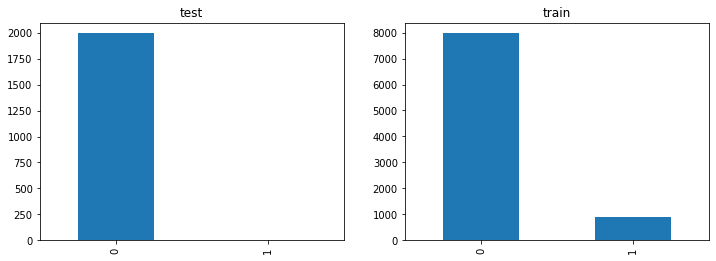

In [16]:
# Visualize distributions of Fraudulent vs Normal activity in the test and train sets

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
fig = plt.figure(1, figsize=(12, 9))


""" Plot the distribution of positive (fraud) vs negative (non-fraud) examples. """
index = ["Pass", "Fraud"]
test.Class.value_counts().plot.bar(ax=axes[0], title='test')
train.Class.value_counts().plot.bar(ax=axes[1], title='train')
train_ct = train.Class.value_counts()
test_ct = test.Class.value_counts()

print("")
print(f"Added {len(synthetic.values)} generated synthetic positive examples to the training set.")
print("Distributions:")
print(f'  -- Train Pass: {train_ct[0]}, Fraud: {train_ct[1]}, Ratio: {round(train_ct[0] / train_ct[1], 2)}:1')
print(f'  -- Test Pass: {test_ct[0]}, Fraud: {test_ct[1]}, Ratio: {round(test_ct[0] / test_ct[1], 2)}:1')

## The metric trap
One of the major issues novel users fall into when dealing with unbalanced datsets relates to the metrics 
used to evaluate the model. Simply using `accuracy_score` can be misleading. In an imbalanced dataset,
if the classifier always predicts the most common class (that a user will not file a claim in this case)
you can still have a high accuracy rate, but miss the real goal of the prediction, which is to 
accurately predict users that will file a claim.


In [17]:
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

def train_classifier(X_train, y_train, X_test, y_test):  
    """Train our predictor with XGBoost"""
    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    np.set_printoptions(precision=2)
    print("XGBoost Model prediction accuracy: %.2f%%" % (accuracy * 100.0))
    return model, y_pred
    
    
# Encode labels and categorical variables before training prediction model
X_train = train.iloc[:, :-1]
y_train = train['Class']

X_test = test.iloc[:, :-1]
y_test = test['Class']

model, y_pred = train_classifier(X_train, y_train, X_test, y_test)

XGBoost Model prediction accuracy: 99.80%


## A better approach, try a confusion matrix

An confusion matrix is often a better way to understand model performance, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. 

Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

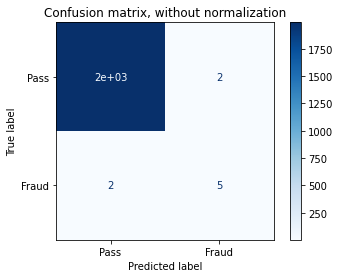

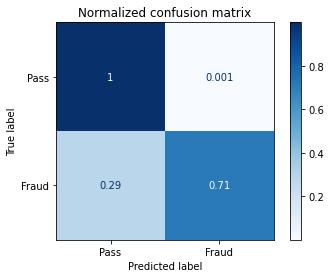

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


def print_confusion_matrix(model, X_test, y_test):
    """ Plot normalized and non-normalized confusion matrices """
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=["Pass", "Fraud"],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

    plt.show()

print_confusion_matrix(model, X_test, y_test)

## Or use accuracy report including f-score

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Print precision / recall report
print('Overall accuracy score :',accuracy_score(y_test, y_pred))
print('Classification report : ')
print(classification_report(y_test, y_pred, target_names=['Pass', 'Fraud']))


Overall accuracy score : 0.998
Classification report : 
              precision    recall  f1-score   support

        Pass       1.00      1.00      1.00      1993
       Fraud       0.71      0.71      0.71         7

    accuracy                           1.00      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       1.00      1.00      1.00      2000



## Create a dataframe for visualizing each class
Let's cluster our data to see if we can see the relationship between our synthetic data
and the positive examples in our training set, as well as how they compare to the
positive examples in the test set

Use PCA decomposition to visualize differences between our highly dimensional sets. We will label each data class as: 
* Training negative: 0
* Training positive: 1
* Synthetic positive: 2 (our synthetic data points used to boost training data)
* Test positive: 3 (not cheating =), we already ran the classifier!)

In [20]:
# Build a new visualization dataframe from our training data
train_vis = train

# Add in positive synthetic results
train_vis = pd.merge(train_only.round(6), synthetic.round(6), indicator=True, how='outer')
train_vis.loc[(train_vis._merge == 'right_only'), 'Class'] = 2
train_vis = train_vis.drop(columns=['_merge'])

# Add in positive results from the test set
train_vis = pd.merge(train_vis.round(6), test[test['Class'] == 1].round(6), indicator=True, how='outer')
train_vis.loc[(train_vis._merge == 'right_only') | (train_vis._merge == 'both'), 'Class'] = 3
train_vis = train_vis.drop(columns=['_merge'])

## Using PCA to visualize highly dimensional data

Many datasets have a large number of variables, and therefore a high number of dimensions along which the data is distributed.
To enable visualization, we'll use a series of techniques called `dimensionality reduction`. One of the most popular
and battle tested techniques for dimensionality reduction is PCA (Principal Component Analysis).

Let's use PCA to visualize our 31-dimension dataset in a 2D graph, and see what we can learn.

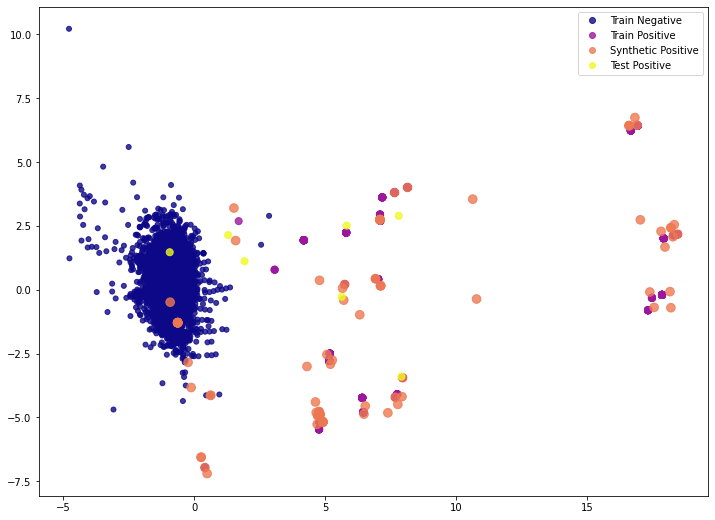

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = train_vis.iloc[:, :-1]
y = train_vis['Class']

fig = plt.figure(1, figsize=(12, 9))
plt.clf()
plt.cla()

pca = PCA(n_components=2)
x_std = StandardScaler().fit_transform(X)
projected = pca.fit_transform(x_std)

if USE_SYNTHETIC_DATA:
    labels = ['Train Negative', 'Train Positive', 'Synthetic Positive', 'Test Positive']
else:
    labels = ['Train Negative', 'Train Positive', 'Test Positive']
size_map = {0:25, 1:50, 2:75, 3:50}
sizes = [size_map[x] for x in y]

scatter = plt.scatter(projected[:, 0], projected[:, 1],
                      c=y,
                      s=sizes,
                      cmap=plt.cm.plasma, 
                      alpha=0.8)

plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.show()



# Interpreting our graph
Above we can see negative samples (in blue), positive examples from our training data (purple), new synthetic data samples that we have added (pink), and the positive examples from the test data that we are trying to predict (yellow).

While many of the synthetic data examples we created are duplicates with the original training data (not surprising, considering we had only 38 examples to train from!), we can see that the synthetic data model
generated additional examples that we have not seen before, and in the vicinity of the existing synthetic data points. 

# Now let's visualize our data in 3D using PCA! 

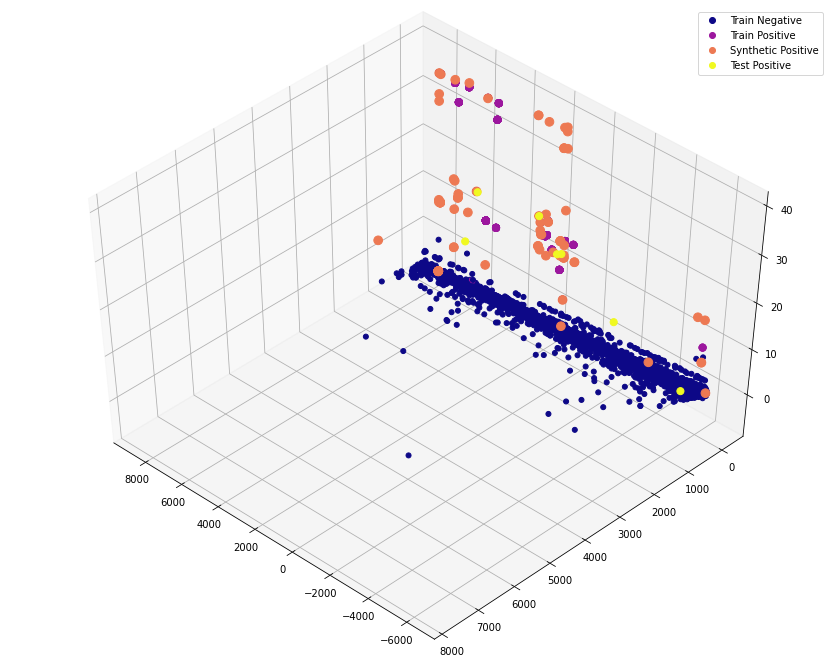

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

X = train_vis.iloc[:, :-1]
y = train_vis['Class']

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

fig = plt.figure(1, figsize=(12, 9))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
pca = decomposition.PCA(n_components=3)

pca.fit(X)
X = pca.transform(X)

scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=sizes, cmap=plt.cm.plasma, alpha=1.0)

plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.show()
